In [1]:
print("all ok")

all ok


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
os.environ["GOOGLE_CSE_ID"]=os.getenv("GOOGLE_CSE_ID")

In [4]:
google_search_api_key =os.getenv("GOOGLE_CSE_ID")

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [6]:
### prompt
from langchain import hub
prompt=hub.pull("rlm/rag-prompt")

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

c:\Users\saxenanidhi\agentic_ai\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

In [8]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

In [9]:
index=faiss.IndexFlatL2(384)

In [10]:
vector_store= FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
)

In [11]:
from uuid import uuid4
from langchain_core.documents import Document
doucment_1=Document(
    page_content="Buildin an imortant project with gen AI",
    metadata={"source":"insta"}
)

In [15]:
doucment_2=Document(
    page_content="Buildin an aem site project with gen AI",
    metadata={"source":"fb"}
)
doucment_3=Document(
    page_content="Buildin an amazing AEP and AEM project with gen AI",
    metadata={"source":"net"}
)
doucment_4=Document(
    page_content="USA president is Trump",
    metadata={"source":"tweet"}
)
doucment_5=Document(
    page_content="Buildin an exceting project on arts wIth gen AI",
    metadata={"source":"chrome"}
)
doucment_6=Document(
    page_content="Buildin an exceting maths work wIth gen AI",
    metadata={"source":"tweet"}
)
doucment_7=Document(
    page_content="Buildin an exceting drawing wIth gen AI",
    metadata={"source":"news"}
)

In [19]:
documents=[
   doucment_1,
   doucment_2,
   doucment_3,
   doucment_4,
   doucment_5,
   doucment_6,
   doucment_7
]

In [20]:
vector_store.add_documents(documents=documents)

['daa737e1-a192-423c-96bc-5cb18a9fbec0',
 'c8159960-951d-4246-a250-8c12fc47d2e1',
 'f525f40e-2eb3-4130-a38c-90edf7ce6320',
 'd431ae73-8a13-42d6-92fb-ba42a31d1eec',
 'c7ec519c-10d3-4024-b316-125f1d4cea4c',
 '2a54ab1a-bd6b-44ee-8ccc-6246acbc23b4',
 'ee054fe5-de52-4bd8-94d4-3acc90674fd9']

In [21]:
### Retriever
retriever=vector_store.as_retriever(search_kwargs={"k":3})

In [22]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END

In [23]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [24]:
from langchain.output_parsers import PydanticOutputParser

In [25]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [26]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [27]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
	


In [28]:
state={"messages":["hi"]}

In [50]:
def function_1(state:AgentState):
    
    question=state["messages"][-1]
        
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Not Related,FAIL,PASS]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

In [53]:
state={"messages":["what is a today weather?"]}

In [54]:
function_1(state)

Question what is a today weather?
Parsed response: Topic='Not Related' Reasoning='The query is a general weather question, not specific to the USA.'


{'messages': ['Not Related']}

In [55]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [56]:
def router(state:AgentState):
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "usa" in last_message.lower():
        return "RAG Call"
    elif "temperature" in last_message.lower() or "not related" in last_message.lower():
        return "WEB Call"
    else:
        return "LLM Call"

In [57]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [58]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [59]:
# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [60]:
# WEB CALL Function
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
def function_4(state:AgentState):
    print("-> WEB Call ->")
    question = state["messages"][0]
    print("-> WEB Call question->"+question)   
    wikipediaAPIWrapper = WikipediaAPIWrapper(top_k_results=5,doc_content_chars_max=5000)
    wiki_tool=WikipediaQueryRun(api_wrapper=wikipediaAPIWrapper) 
    result=wiki_tool.run({"query":question})
    print(result)
    return result


In [61]:
state={"messages":["what is the temperature today in noida"]}

In [62]:
function_4(state)



-> WEB Call ->
-> WEB Call question->what is the temperature today in noida
Page: Noida
Summary: Noida (Hindi: [noːeːɖaː]), short for New Okhla Industrial Development Authority (ISO: Navīna Ōkhalā Audyōgika Vikāsa Prādhikaraṇa), is a city located in Gautam Buddha Nagar district of the Indian state of Uttar Pradesh. As per provisional reports of Census of India, the population of Noida in 2011 was 642,381. The city is managed by New Okhla Industrial Development Authority (NOIDA). The district's administrative headquarters are in the nearby city of Greater Noida.
The city is a part of the Noida (Vidhan Sabha) constituency and Gautam Buddha Nagar (Lok Sabha) constituency. Noida was ranked as the "Best City in Uttar Pradesh" in the "Best City Awards" conducted by ABP News in 2015. It is also ranked the cleanest city in medium category cities (cities with a population of 300,000 to 1,000,000) and 4th cleanest city among cities with less than 1,000,000 people.

Page: Greater Noida
Summary: G

'Page: Noida\nSummary: Noida (Hindi: [noːeːɖaː]), short for New Okhla Industrial Development Authority (ISO: Navīna Ōkhalā Audyōgika Vikāsa Prādhikaraṇa), is a city located in Gautam Buddha Nagar district of the Indian state of Uttar Pradesh. As per provisional reports of Census of India, the population of Noida in 2011 was 642,381. The city is managed by New Okhla Industrial Development Authority (NOIDA). The district\'s administrative headquarters are in the nearby city of Greater Noida.\nThe city is a part of the Noida (Vidhan Sabha) constituency and Gautam Buddha Nagar (Lok Sabha) constituency. Noida was ranked as the "Best City in Uttar Pradesh" in the "Best City Awards" conducted by ABP News in 2015. It is also ranked the cleanest city in medium category cities (cities with a population of 300,000 to 1,000,000) and 4th cleanest city among cities with less than 1,000,000 people.\n\nPage: Greater Noida\nSummary: Greater Noida is a planned city located in the Gautam Buddha Nagar dis

In [77]:
def function_5(state:AgentState):
    res =state["messages"][-1]
    if "unrelated" in res.lower():
        return {"messages":["FAIL"]}

In [78]:
from langgraph.graph import StateGraph,END

In [79]:
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("WEB",function_4)
workflow.add_node("VALIDATOR",function_5)
workflow.set_entry_point("Supervisor")


In [80]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "WEB Call": "WEB",
    }
)

In [81]:
## TO VALIDATE RESPONSE
workflow.add_edge("RAG","VALIDATOR")
workflow.add_edge("LLM","VALIDATOR")
workflow.add_edge("WEB","VALIDATOR")

workflow.add_edge("VALIDATOR","Supervisor")

In [82]:

workflow.add_edge("VALIDATOR",END)

In [83]:
app=workflow.compile()

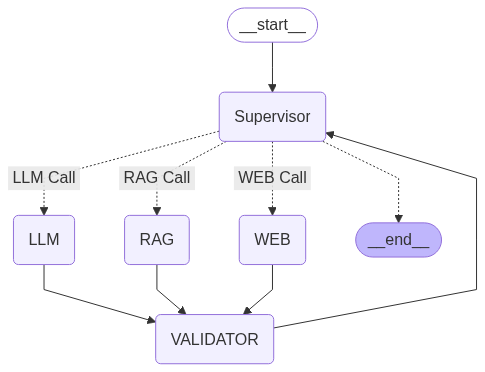

In [84]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [90]:
state={"messages":["who is the president of INDIA?"]}

In [91]:
app.invoke(state)

Question who is the president of INDIA?
Parsed response: Topic='Not Related' Reasoning='The query is about the president of India, which is not related to the USA.'
-> ROUTER ->
last_message: Not Related
-> WEB Call ->
-> WEB Call question->who is the president of INDIA?
Page: President of India
Summary: The president of India  (ISO: Bhārata kē Rāṣṭrapati) is the head of state of the Republic of India. The president is the nominal head of the executive, the first citizen of the country, and the supreme commander of the Indian Armed Forces. Droupadi Murmu is the 15th and current president, having taken office on 25 July 2022.
The office of president was created when India's  constitution came into force and it became a republic on 26 January 1950. The president is indirectly elected by an electoral college comprising both houses of the Parliament of India and the legislative assemblies of each of India's states and territories, who themselves are all directly elected by the citizens.
Ar

InvalidUpdateError: Expected dict, got Page: President of India
Summary: The president of India  (ISO: Bhārata kē Rāṣṭrapati) is the head of state of the Republic of India. The president is the nominal head of the executive, the first citizen of the country, and the supreme commander of the Indian Armed Forces. Droupadi Murmu is the 15th and current president, having taken office on 25 July 2022.
The office of president was created when India's  constitution came into force and it became a republic on 26 January 1950. The president is indirectly elected by an electoral college comprising both houses of the Parliament of India and the legislative assemblies of each of India's states and territories, who themselves are all directly elected by the citizens.
Article 53 of the Constitution of India states that the president can exercise their powers directly or by subordinate authority, though all of the executive powers vested in the president are, in practice, exercised by the prime minister heading the Council of Ministers. The president is bound by the constitution to act on the advice of the council and to enforce the decrees passed by the Supreme Court under article 142.



Page: List of presidents of India
Summary: The president of India is the head of state of the Republic of India and the supreme commander of the Indian Armed Forces. The president is referred to as the first citizen of India. Although vested with these powers by the Constitution of India, the position is largely a ceremonial one and executive powers are de facto exercised by the prime minister.
The president is elected by the Electoral College composed of elected members of the parliament houses, the Lok Sabha and the Rajya Sabha, and also members of the Saasana Sabha or Vidhan Sabha, the state legislative assemblies. Presidents may remain in office for a tenure of five years, as stated by article 56, part V, of the Constitution of India. In the case where a president's term of office is terminated early or during the absence of the president, the vice president assumes office. By article 70 of part V, the parliament may decide how to discharge the functions of the president where this is not possible, or in any other unexpected contingency.
There have been 15 presidents of India since the post was established when India was declared as a republic with the adoption of the Indian constitution in 1950. Apart from these fifteen, three acting presidents have also been in office for short periods of time. V. V. Giri became the acting president in 1969 after Zakir Husain died in office. Giri was elected president a few months later. He remains the only person to have held office both as a president and acting president. Rajendra Prasad, the first president of India, is the only person to have held office for two terms.
Seven presidents have been members of a political party before being elected. Six of these were active party members of the Indian National Congress. The Janata Party has had one member, Neelam Sanjiva Reddy, who later became president. Two presidents, Zakir Husain and Fakhruddin Ali Ahmed, have died in office. Their vice presidents served as acting presidents until a new president was elected. Following Zakir Husain's death, two acting presidents held office until the new president, V. V. Giri, was elected. When Giri resigned to take part in the presidential elections, he was succeeded by Mohammad Hidayatullah as acting president. Pratibha Patil is the first woman to hold the office, elected in 2007.
On 25 July 2022, Droupadi Murmu took office as the president of India, becoming the second woman and the first tribal person to hold the office.



Page: Vice President of India
Summary: The vice president of India (ISO: Bhārata kē Uparāṣṭrapati) is the deputy to the head of state of the Republic of India, i.e. the president of India. The office of vice president is the second-highest constitutional office after the president and ranks second in the order of precedence and first in the line of succession to the presidency. The vice president is also the ex officio chairman of the Rajya Sabha.
Article 66 of the Constitution of India states the manner of election of the vice president. The vice president is elected indirectly by members of an electoral college consisting of the members of both Houses of Parliament and not the members of state legislative assembly by the system of proportional representation using single transferable votes and the voting is conducted by Election Commission of India via secret ballot. The vice president also acts as the chancellor of the Panjab University and Delhi University.
Jagdeep Dhankhar of the Bharatiya Janata Party is the current vice president. He became vice president after defeating Indian National Congress candidate Margaret Alva in the 2022 Indian vice presidential election.

Page: List of vice presidents of India
Summary: The vice president of India is the second highest constitutional office in the government of India after 
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE

In [127]:
state={"messages":["tell me the today's temperature of noida ?"]}

In [128]:
app.invoke(state)

Question tell me the today's temperature of noida ?
Parsed response: Topic='Not Related' Reasoning='The query asks for the temperature in Noida, India, which is not related to the USA.'
-> ROUTER ->
last_message: Not Related
-> WEB Call ->
-> WEB Call question->tell me the today's temperature of noida ?
Page: Paatal Lok
Summary: Paatal Lok (transl. Netherworld)
is an Indian neo-noir crime thriller television series on Amazon Prime Video, created by Sudip Sharma, who wrote the script along with Sagar Haveli, Hardik Mehta and Gunjit Chopra, and directed by Avinash Arun and Prosit Roy. The series was produced under the banner Clean Slate Filmz, and stars Jaideep Ahlawat, Gul Panag, Neeraj Kabi, Swastika Mukherjee, Ishwak Singh, Abhishek Banerjee, Niharika Lyra Dutt, and Richa Chaturvedi. Loosely based on Tarun Tejpal's 2010 novel The Story of My Assassins, the first season is about a disillusioned cop who lands the case of an assassination attempt gone wrong. Ahlawat, Singh, and Panag rep

InvalidUpdateError: Expected dict, got Page: Paatal Lok
Summary: Paatal Lok (transl. Netherworld)
is an Indian neo-noir crime thriller television series on Amazon Prime Video, created by Sudip Sharma, who wrote the script along with Sagar Haveli, Hardik Mehta and Gunjit Chopra, and directed by Avinash Arun and Prosit Roy. The series was produced under the banner Clean Slate Filmz, and stars Jaideep Ahlawat, Gul Panag, Neeraj Kabi, Swastika Mukherjee, Ishwak Singh, Abhishek Banerjee, Niharika Lyra Dutt, and Richa Chaturvedi. Loosely based on Tarun Tejpal's 2010 novel The Story of My Assassins, the first season is about a disillusioned cop who lands the case of an assassination attempt gone wrong. Ahlawat, Singh, and Panag reprised their roles in the second season (set amidst political turmoil in Nagaland), and were joined by Tillotama Shome, Jahnu Barua, Nagesh Kukunoor and Prashant Tamang.
Sudip Sharma wrote the script in January 2017, and took more than a year for writing and pre-production. It is filmed across more than 110 real locations, with Paatal Lok being the first series to be shot at Chitrakoot. The cinematography for the series were handled by Avinash Arun and Saurabh Goswami, with editing done by Sanyukta Kaza. The background score was jointly composed by Naren Chandravarkar and Benedict Taylor.
The first season of Paatal Lok was premiered on Amazon Prime Video on 15 May 2020. The series received rave reviews from critics, praising the performances, storyline, writing and direction.  The series were listed in the Top 10 Indian Web Series of 2020, by The Indian Express. Variety listed Paatal Lok as one of the best international TV shows of 2020. In May 2020, the makers announced that the second season is to be conceptualized. The second season was released on 17 January 2025.
Paatal Lok received eight nominations at the inaugural Filmfare OTT Awards, and won five awards – Best Actor (Jaideep Ahlawat), Best Series, Best Original Story, Best Screenplay and Best Direction (Avinash Arun and Prosit Roy).

Page: Economy of India
Summary: The economy of India is a developing mixed economy with a notable public sector in strategic sectors. It is the world's fourth-largest economy by nominal GDP and the third-largest by purchasing power parity (PPP); on a per capita income basis, India ranked 136th by GDP (nominal) and 119th by GDP (PPP). From independence in 1947 until 1991, successive governments followed the Soviet model and promoted protectionist economic policies, with extensive Sovietization, state intervention, demand-side economics, natural resources, bureaucrat-driven enterprises and economic regulation. This is characterised as dirigism, in the form of the Licence Raj. The end of the Cold War and an acute balance of payments crisis in 1991 led to the adoption of a broad economic liberalisation in India and indicative planning. India has about 1,900 public sector companies, with the Indian state having complete control and ownership of railways and highways. The Indian government has major control over banking, insurance, farming, fertilizers and chemicals, airports,  essential utilities. The state also exerts substantial control over digitalization,  telecommunication, supercomputing, space, port and shipping industries, which were effectively nationalised in the mid-1950s but has seen the emergence of key corporate players.
Nearly 70% of India's GDP is driven by domestic consumption; the country remains the world's fourth-largest consumer market. Aside private consumption, India's GDP is also fueled by government spending, investments, and exports. In 2022, India was the world's 10th-largest importer and the 8th-largest exporter. India has been a member of the World Trade Organization since 1 January 1995. It ranks 63rd on the ease of doing business index and 40th on the Global Competitiveness Index. India has one of the world's highest number of billionaires along with extreme income inequality. Economists and social scientists often consider India a welfare state. India's overall social welfare spending stood at 8.6% of GDP in 2021-22, which is much lower than the average for OECD nations. With 586 million workers, the Indian labour force is the world's second-largest. Despite having one of the longest working hours, India has one of the lowest workforce productivity levels in the world. Economists say that due to structural economic problems, India is experiencing jobless economic growth.
During the Great Recession, the economy faced a mild slowdown. India endorsed Keynesian policy and initiated stimulus measures (both fiscal and monetary) to boost growth and generate demand. In subsequent years, economic growth revived.
In 2021–22, the foreign direct investment (FDI) in India was $82 billion. The leading sectors for FDI inflows were the Finance, Banking, Insurance and R&D. India has free trade agreements with several nations and blocs, including ASEAN, SAFTA, Mercosur, South Korea, Japan, Australia, the United Arab Emirates, and
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE